## Load Data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [12]:
df = pd.read_csv('../dataset/after_selection/train.csv')
df.head()

,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Bin,Vehicle_Damage_Age_Interaction,Response
0,1,46.0,1,0,0,152.0,0,0,0
1,1,46.0,1,0,0,152.0,0,0,0
2,1,46.0,1,1,1,26.0,2,2,0
3,1,18.0,1,0,0,152.0,1,0,0
4,1,11.0,0,1,1,122.0,2,2,0


## 1. Modeling

### Split Data Train & Test

In [13]:
X = df.drop(columns=['Response'])
y = df[['Response']]

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Algoritma Modeling

#### Evaluation Method

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold


def eval_classification(model, X_train, X_test, y_train, y_test, n_splits=5):
    # Evaluate on the test set
    y_pred_test = model.predict(X_test)

    # StratifiedKFold for cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_test_results = cross_validate(model, X_test, y_test, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    cv_train_results = cross_validate(model, X_train, y_train, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)


    # Display metrics for the training set
    print("Metrics for the Test Set:")
    print("Accuracy: %.2f" % accuracy_score(y_test, y_pred_test))
    print("Precision: %.2f" % precision_score(y_test, y_pred_test))
    print("Recall: %.2f" % recall_score(y_test, y_pred_test))
    print("F1-Score: %.2f" % f1_score(y_test, y_pred_test))
    print()

    # Display cross-validation results
    print("Metrics Using Cross Validation:")
    print(f"Mean ROC-AUC (Test): {cv_test_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Test): {cv_test_results['test_roc_auc'].std():.2f}")
    print()
    print(f"Mean ROC-AUC (Train): {cv_train_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Train): {cv_train_results['test_roc_auc'].std():.2f}")

#### CatBoost

In [16]:
base_model = CatBoostClassifier()
base_model.fit(X_train, y_train)

Learning rate set to 0.06155
0:	learn: 0.6384054	total: 53.1ms	remaining: 53.1s
1:	learn: 0.5966405	total: 58.4ms	remaining: 29.1s
2:	learn: 0.5636985	total: 64.1ms	remaining: 21.3s
3:	learn: 0.5388866	total: 69.4ms	remaining: 17.3s
4:	learn: 0.5195404	total: 74.9ms	remaining: 14.9s
5:	learn: 0.5050662	total: 80.6ms	remaining: 13.4s
6:	learn: 0.4930574	total: 86.8ms	remaining: 12.3s
7:	learn: 0.4840600	total: 93.4ms	remaining: 11.6s
8:	learn: 0.4763112	total: 99.9ms	remaining: 11s
9:	learn: 0.4701030	total: 106ms	remaining: 10.5s
10:	learn: 0.4649680	total: 112ms	remaining: 10.1s
11:	learn: 0.4608034	total: 117ms	remaining: 9.67s
12:	learn: 0.4578170	total: 122ms	remaining: 9.23s
13:	learn: 0.4545915	total: 128ms	remaining: 9s
14:	learn: 0.4520754	total: 134ms	remaining: 8.77s
15:	learn: 0.4497790	total: 139ms	remaining: 8.54s
16:	learn: 0.4479879	total: 144ms	remaining: 8.35s
17:	learn: 0.4464629	total: 150ms	remaining: 8.18s
18:	learn: 0.4452445	total: 155ms	remaining: 7.99s
19:	lear

In [17]:
eval_classification(base_model, X_train, X_test, y_train, y_test)

Streaming output truncated to the last 5000 lines.
16:	learn: 0.4526944	total: 86.5ms	remaining: 5s
17:	learn: 0.4516153	total: 90.5ms	remaining: 4.94s
18:	learn: 0.4497242	total: 95.5ms	remaining: 4.93s
19:	learn: 0.4485326	total: 99.8ms	remaining: 4.89s
20:	learn: 0.4468341	total: 105ms	remaining: 4.88s
21:	learn: 0.4455699	total: 110ms	remaining: 4.89s
22:	learn: 0.4443453	total: 115ms	remaining: 4.88s
23:	learn: 0.4433616	total: 120ms	remaining: 4.89s
24:	learn: 0.4423571	total: 125ms	remaining: 4.88s
25:	learn: 0.4420073	total: 128ms	remaining: 4.8s
26:	learn: 0.4411128	total: 133ms	remaining: 4.8s
27:	learn: 0.4402432	total: 138ms	remaining: 4.8s
28:	learn: 0.4395044	total: 143ms	remaining: 4.8s
29:	learn: 0.4392466	total: 147ms	remaining: 4.75s
30:	learn: 0.4386974	total: 152ms	remaining: 4.74s
31:	learn: 0.4381368	total: 157ms	remaining: 4.75s
32:	learn: 0.4377351	total: 162ms	remaining: 4.75s
33:	learn: 0.4374164	total: 166ms	remaining: 4.73s
34:	learn: 0.4370030	total: 171ms	

Metrics for the Test Set:
- Accuracy: 0.80
- Precision: 0.73
- Recall: 0.93
- F1-Score: 0.82

Metrics Using Cross Validation:
- Mean ROC-AUC (Test): 0.84
- Std ROC-AUC (Test): 0.01
- Mean ROC-AUC (Train): 0.85
- Std ROC-AUC (Train): 0.00

### Hyperparameter Tunning

In [18]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [19]:
cat_model = CatBoostClassifier()

In [20]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'depth': [4, 8],
    'l2_leaf_reg': [1, 5],
    'iterations': [100],
    'border_count': [32, 64],
    'custom_metric': ['Logloss', 'AUC'],
    'auto_class_weights': ['None', 'Balanced']
}

In [21]:
random_search = RandomizedSearchCV(estimator=cat_model, param_distributions=param_grid, n_iter=5, cv=3, scoring='roc_auc', n_jobs=-1)
random_search.fit(X_train, y_train)

0:	learn: 0.6890655	total: 5.63ms	remaining: 558ms
1:	learn: 0.6850637	total: 10.9ms	remaining: 533ms
2:	learn: 0.6811350	total: 15.8ms	remaining: 511ms
3:	learn: 0.6772858	total: 21.2ms	remaining: 510ms
4:	learn: 0.6735023	total: 27ms	remaining: 514ms
5:	learn: 0.6697812	total: 31.5ms	remaining: 493ms
6:	learn: 0.6661343	total: 36.3ms	remaining: 482ms
7:	learn: 0.6626011	total: 39.5ms	remaining: 454ms
8:	learn: 0.6590730	total: 44.3ms	remaining: 448ms
9:	learn: 0.6556344	total: 48.2ms	remaining: 434ms
10:	learn: 0.6522475	total: 52.4ms	remaining: 424ms
11:	learn: 0.6489514	total: 56.1ms	remaining: 411ms
12:	learn: 0.6456874	total: 59.8ms	remaining: 400ms
13:	learn: 0.6424539	total: 64.3ms	remaining: 395ms
14:	learn: 0.6393555	total: 67.6ms	remaining: 383ms
15:	learn: 0.6363048	total: 71.4ms	remaining: 375ms
16:	learn: 0.6332742	total: 75.8ms	remaining: 370ms
17:	learn: 0.6303369	total: 79.4ms	remaining: 362ms
18:	learn: 0.6274175	total: 83ms	remaining: 354ms
19:	learn: 0.6244726	total

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x785e6e53e440>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'auto_class_weights': ['None',
                                                               'Balanced'],
                                        'border_count': [32, 64],
                                        'custom_metric': ['Logloss', 'AUC'],
                                        'depth': [4, 8], 'iterations': [100],
                                        'l2_leaf_reg': [1, 5],
                                        'learning_rate': [0.01, 0.1]},
                   scoring='roc_auc')

In [22]:
# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 100, 'depth': 8, 'custom_metric': 'Logloss', 'border_count': 32, 'auto_class_weights': 'Balanced'}


In [23]:
# Get the best model from grid search
best_cat_model = random_search.best_estimator_

### Best Result

In [24]:
eval_classification(best_cat_model, X_train, X_test, y_train, y_test)

0:	learn: 0.6890941	total: 1.7ms	remaining: 168ms
1:	learn: 0.6851165	total: 3.31ms	remaining: 162ms
2:	learn: 0.6812079	total: 4.72ms	remaining: 153ms
3:	learn: 0.6773943	total: 6.35ms	remaining: 152ms
4:	learn: 0.6736454	total: 8.2ms	remaining: 156ms
5:	learn: 0.6700413	total: 9.96ms	remaining: 156ms
6:	learn: 0.6664236	total: 12ms	remaining: 159ms
7:	learn: 0.6629013	total: 13.2ms	remaining: 151ms
8:	learn: 0.6594800	total: 15.2ms	remaining: 154ms
9:	learn: 0.6560537	total: 16.6ms	remaining: 149ms
10:	learn: 0.6526961	total: 18.7ms	remaining: 151ms
11:	learn: 0.6493901	total: 20.2ms	remaining: 148ms
12:	learn: 0.6461791	total: 21.6ms	remaining: 144ms
13:	learn: 0.6430303	total: 22.8ms	remaining: 140ms
14:	learn: 0.6398947	total: 24.7ms	remaining: 140ms
15:	learn: 0.6368280	total: 26.1ms	remaining: 137ms
16:	learn: 0.6338263	total: 27.7ms	remaining: 135ms
17:	learn: 0.6308673	total: 29.2ms	remaining: 133ms
18:	learn: 0.6279897	total: 30.4ms	remaining: 130ms
19:	learn: 0.6251556	total

Metrics for the Test Set:
- Accuracy: 0.78
- Precision: 0.70
- Recall: 0.90
- F1-Score: 0.79

Metrics Using Cross Validation:
- Mean ROC-AUC (Test): 0.84
- Std ROC-AUC (Test): 0.01
- Mean ROC-AUC (Train): 0.84
- Std ROC-AUC (Train): 0.00

In [26]:
filename = './models/catboost_model.sav'
pickle.dump(best_cat_model, open(filename, 'wb'))

## Feature Importance

                          Feature  Importance
0                 Driving_License    0.225561
1                     Region_Code    1.175345
3                     Vehicle_Age    3.473994
5            Policy_Sales_Channel    4.683002
7  Vehicle_Damage_Age_Interaction    8.888457
6                         Age_Bin   12.444699
4                  Vehicle_Damage   25.820344
2              Previously_Insured   43.288599


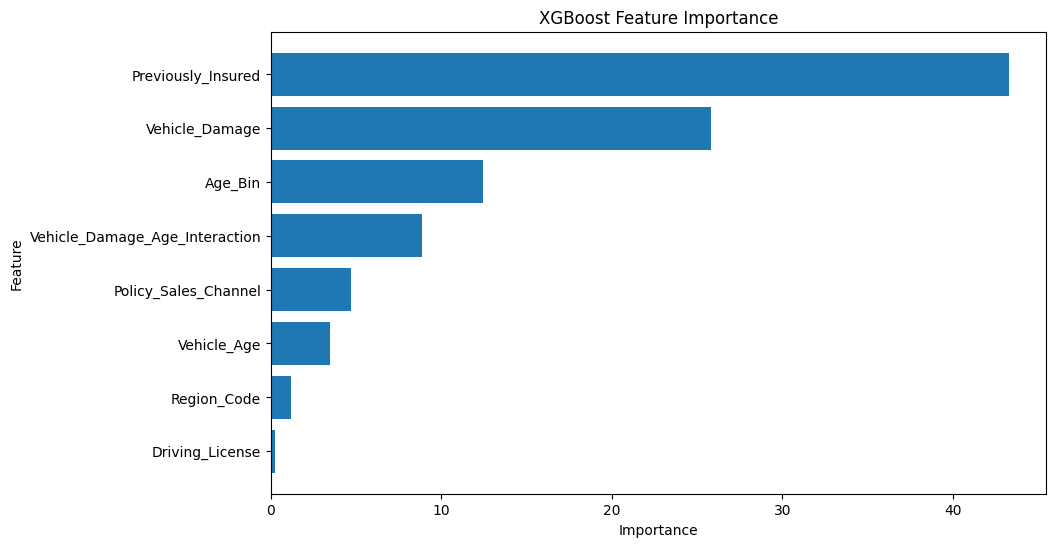

In [27]:
# Get feature importances
feature_importances = best_cat_model.feature_importances_

# Get feature names (optional)
feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for better visualization (optional)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Print or plot the feature importance
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()